Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from surprise import Dataset, Reader, SVD, accuracy
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split, cross_validate

Dataset describing and analyzing and visualizing

In [2]:
def read_dataset(df):
    return pd.read_csv(df)

def dataset_head(df, limit = 5):
    return df.head(limit)

def dataset_tail(df, limit = 5):
    return df.tail(limit)

def dataset_info(df):
    return df.info()

def dataset_describe(df):
    return df.describe()

def dataset_missing_values(df):
    return df.isnull().sum()

def dataset_columns(df):
    return df.columns

def dataset_shape(df):
    return df.shape

def dataset_numerical_columns(df):
    return df.select_dtypes(include = ['int64', 'float64']).columns

def dataset_categorical_columns(df):
    return df.select_dtypes(include = ['object']).columns

def check_unique_values(df):
    return df.nunique()

def check_unique_value_for_a_column(df, column):
    return df[column].nunique()

def drop_column(df, column):
    return df.drop(column, axis = 1)


In [3]:
def hist_plot(df, column):
    sns.histplot(df[column], bins = 10, kde = False)
    plt.title(f"Distribution of {column}")
    plt.show()

Load dataset

In [4]:
movies = read_dataset('ml-latest-small/movies.csv')
ratings = read_dataset('ml-latest-small/ratings.csv')
# links = read_dataset('ml-latest-small/links.csv')
# tags = read_dataset('ml-latest-small/tags.csv')

In [5]:
dataset_head(movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
dataset_head(ratings)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Check Missing Values

In [7]:
print(dataset_missing_values(movies))
print("---------------")
print(dataset_missing_values(ratings))

movieId    0
title      0
genres     0
dtype: int64
---------------
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Dataframes shape

In [8]:
print(f"movie dataset shape: {dataset_shape(movies)}")
print(f"rating dataset shape: {dataset_shape(ratings)}")

movie dataset shape: (9742, 3)
rating dataset shape: (100836, 4)


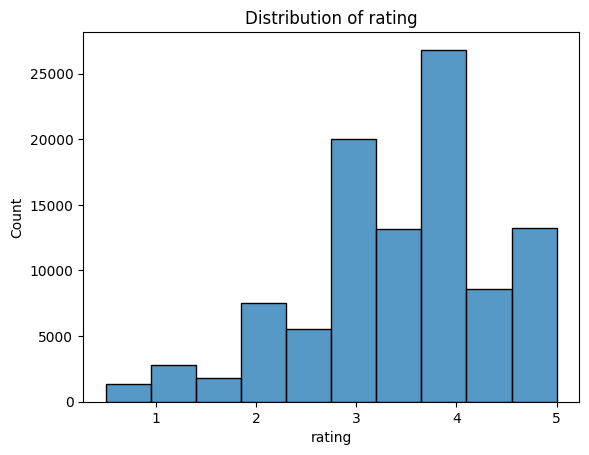

In [9]:
hist_plot(ratings, 'rating')

In [10]:
print(f"Number of unique movies: {check_unique_value_for_a_column(movies, 'movieId')}")
print(f"Number of unique users: {check_unique_value_for_a_column(ratings, 'userId')}")

Number of unique movies: 9742
Number of unique users: 610


Preprocessing

In [11]:
merged_df = ratings.merge(movies, on = 'movieId')
print(dataset_head(merged_df))

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


In [12]:
print(dataset_shape(merged_df))

(100836, 6)


In [13]:
merged_df['genres'] = merged_df['genres'].str.split('|')

In [14]:
dataset_head(merged_df)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,964981247,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,6,4.0,964982224,Heat (1995),"[Action, Crime, Thriller]"
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,50,5.0,964982931,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"


In [15]:
drop_column(merged_df, 'timestamp')

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,6,4.0,Heat (1995),"[Action, Crime, Thriller]"
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,50,5.0,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),"[Drama, Horror, Thriller]"
100832,610,168248,5.0,John Wick: Chapter Two (2017),"[Action, Crime, Thriller]"
100833,610,168250,5.0,Get Out (2017),[Horror]
100834,610,168252,5.0,Logan (2017),"[Action, Sci-Fi]"


Implementing Collaborative Filtering

In [16]:
reader = Reader(rating_scale = (0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.2)
svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)
print(f"accuracy: {rmse(predictions)}")

RMSE: 0.8762
accuracy: 0.8762025716686729


Make Recommendation for a User

In [24]:
def get_recommendation(userId, num_recommendations = 10):
    all_movie_ids = ratings['movieId'].unique()
    rated_movie_ids = ratings[ratings['userId'] == userId]['movieId'].unique()
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)
    predictions = [
        (movie, svd.predict(userId, movie).est) for movie in unrated_movie_ids
    ]
    # print(predictions)
    predictions.sort(key=lambda x: x[1], reverse=True)
    recommended_movies = predictions[:num_recommendations]
    # print(recommended_movies)
    recommendation = movies[movies['movieId'].isin([rec[0] for rec in recommended_movies])]
    # print(recommendation)
    recommendation['predicted_rating'] = [rec[1] for rec in recommended_movies]
    print(recommendation)
    return recommendation[['title','predicted_rating']]

recommendation = get_recommendation(1)
# print(recommendation)

     movieId                                              title  \
277      318                   Shawshank Redemption, The (1994)   
602      750  Dr. Strangelove or: How I Learned to Stop Worr...   
694      912                                  Casablanca (1942)   
841     1104                   Streetcar Named Desire, A (1951)   
883     1178                              Paths of Glory (1957)   
896     1193             One Flew Over the Cuckoo's Nest (1975)   
901     1199                                      Brazil (1985)   
903     1201  Good, the Bad and the Ugly, The (Buono, il bru...   
905     1203                                12 Angry Men (1957)   
906     1204                          Lawrence of Arabia (1962)   

                       genres  predicted_rating  
277               Crime|Drama               5.0  
602                Comedy|War               5.0  
694             Drama|Romance               5.0  
841                     Drama               5.0  
883         

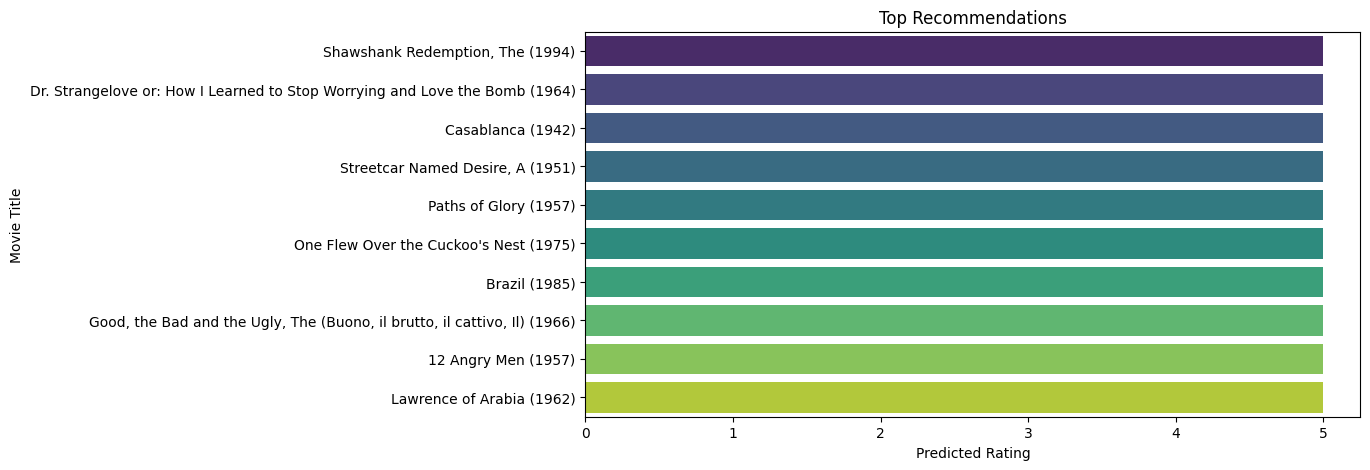

In [20]:
# Plot top recommendations
plt.figure(figsize=(10, 5))
sns.barplot(
    y=recommendation['title'], 
    x=recommendation['predicted_rating'], 
    palette='viridis'
)
plt.title('Top Recommendations')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')
plt.show()